## Install Dependencies


### torch, torchvision

In [1]:
# install torch and torchvision
!pip3 install torch torchvision torchaudio torchtext --extra-index-url https://download.pytorch.org/whl/cu116

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/, https://download.pytorch.org/whl/cu116


### pytorch3d

In [2]:
import os
import torch

try:
    import pytorch3d
except ModuleNotFoundError:
    !curl -LO https://github.com/NVIDIA/cub/archive/1.10.0.tar.gz
    !tar xzf 1.10.0.tar.gz
    os.environ["CUB_HOME"] = os.getcwd() + "/cub-1.10.0"
    !pip install git+https://github.com/facebookresearch/pytorch3d.git

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100  404k    0  404k    0     0   803k      0 --:--:-- --:--:-- --:--:--  803k
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/facebookresearch/pytorch3d.git to /tmp/pip-req-build-8aumxzkx
  Running command git clone -q https://github.com/facebookresearch/pytorch3d.git /tmp/pip-req-build-8aumxzkx
     |████████████████████████████████| 50 kB 3.6 MB/s 
     |████████████████████████████████| 42 kB 1.1 MB/s 
  Created wheel for pytorch3d: filename=pytorch3d-0.7.1-cp38-cp38-linux_x86_64.whl size=51597270 sha256=f77fb7242bdf6050aef6f86b59af811f2719dad3d295b2c7d3a066cac87edf9f
  Stored in directory: /tmp/pip-ephem-wheel-cache-8crc9bls/wheels/5e/a7/7c/814c3888eaaecaaf0f533faeb3c68

In [3]:
import pytorch3d
pytorch3d.__version__

'0.7.1'

### SMPL / Meshes

In [4]:
!pip install smplpytorch
!pip install chumpy
!pip install trimesh

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 50 kB 3.7 MB/s 
  Created wheel for chumpy: filename=chumpy-0.70-py3-none-any.whl size=58286 sha256=c13a229ba18c099c202878c0f81c307906b5294218e83f651dd8e253d4eb4140
  Stored in directory: /root/.cache/pip/wheels/d9/a2/b8/b8aeeeaeb01b5002085156add1aed832f2fb03e79d0f22dfed
Successfully built chumpy
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 669 kB 7.2 MB/s 


### CLIP

In [5]:
!pip install ftfy regex tqdm
!pip install git+https://github.com/openai/CLIP.git

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 53 kB 1.6 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-rc3roq4d
  Running command git clone -q https://github.com/openai/CLIP.git /tmp/pip-req-build-rc3roq4d
  Created wheel for clip: filename=clip-1.0-py3-none-any.whl size=1369408 sha256=d150d40bdcd7e9f28399261ced057f4ff00e614a8b91fee2942e770089cee9d6
  Stored in directory: /tmp/pip-ephem-wheel-cache-a9szzhmf/wheels/ab/4f/3a/5e51521b55997aa6f0690e095c08824219753128ce8d9969a3
Successfully built clip


## GPU

In [6]:
import torch

torch.cuda.is_available()

True

In [7]:
!nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2021 NVIDIA Corporation
Built on Sun_Feb_14_21:12:58_PST_2021
Cuda compilation tools, release 11.2, V11.2.152
Build cuda_11.2.r11.2/compiler.29618528_0


In [8]:
# GPU or CPU
gpu, cpu = None, None
if torch.cuda.is_available():
    gpu = torch.device("cuda:0")
    torch.cuda.set_device(gpu)
else:
    cpu = torch.device("cpu")
dev = gpu if gpu is not None else cpu
dev

device(type='cuda', index=0)

## Setup

### Codebase Loading

In [71]:
!rm -rf project #remove if it already exists 
!git clone https://github.com/B4Farouk/smpl-dr-clip project
!rm -rf sample_data

Cloning into 'project'...
remote: Enumerating objects: 732, done.
remote: Counting objects: 100% (110/110), done.
remote: Compressing objects: 100% (80/80), done.
remote: Total 732 (delta 60), reused 67 (delta 30), pack-reused 622
Receiving objects: 100% (732/732), 68.71 MiB | 34.75 MiB/s, done.
Resolving deltas: 100% (428/428), done.


### Local Imports 

In [70]:
from project.aux_functions import *

from project.smpl import SMPLwrapper, mesh_from
from project.textures import TexturesFactory
from project.rendering import CamerasFactory, Renderer
from project.clipwrapper import CLIPwrapper

from project.optimization import OptimEnv, init_weights
from project.model import compose, SimpledCLIPContext

import trimesh

import clip

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Test: SMPL and Rendering

In [11]:
# initalize a textures factory
txfactory = TexturesFactory(device=dev)
colored_reference_SMPL = trimesh.load("project/SMPL_female_with_colors.obj", process=False)
# use the texture factory to create a texture generator: a function that takes faces and creates a texture
def texture_generator(verts,faces):
  return txfactory.from_image(colored_reference_SMPL ,verts, faces)
# pose and shape initalization
pose_vect = torch.zeros((1, 72), device=dev) # theta, used in optimization
shape_vect = torch.ones((1, 10), device=dev) # beta, not used in optimization
# create the smpl model
smpl_model = SMPLwrapper(model=None, batchsize=5, txmapping=texture_generator, device=dev) #model=None uses the default model
# create the mesh
meshes = smpl_model.meshes(theta=pose_vect, beta=shape_vect)

In [12]:
# create a cameras factory
camsfactory = CamerasFactory(device=dev)
# cameras' spherical coordinates
radiuses = [2]*5
azimuths = (0, 45, 135, -45, -135)
elevations = [10]*5
coords = (radiuses, azimuths, elevations)
# create cameras using cameras factory
cameras = camsfactory.fov_persp_scs(coords=coords, fov=60, frustrum_depth=(1, 100))
# create a renderer
renderer = Renderer(device=dev, cameras=cameras)
# render the textured meshes generated by SMPL
test_imgs_t = renderer.render(meshes)
# shape of the rendered images
test_imgs_t.shape

torch.Size([5, 244, 244, 4])

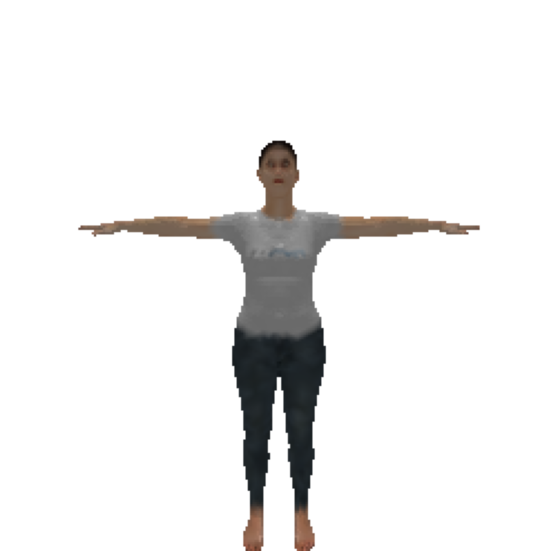

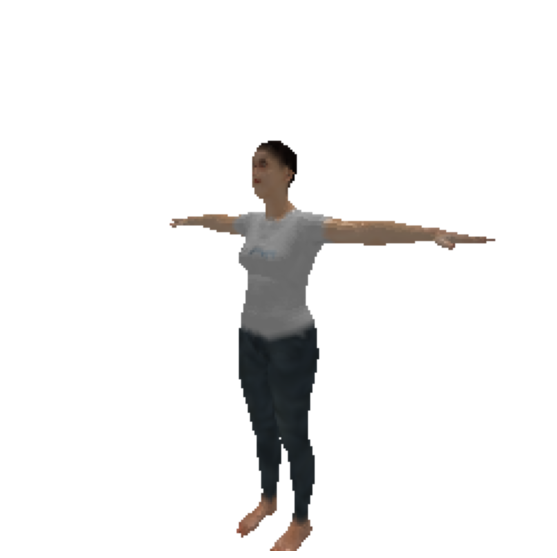

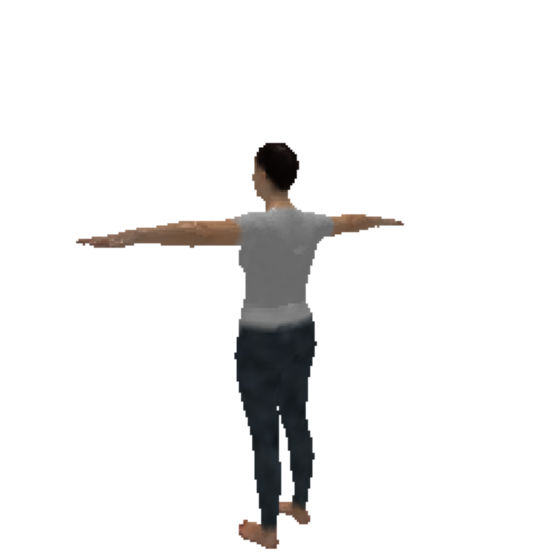

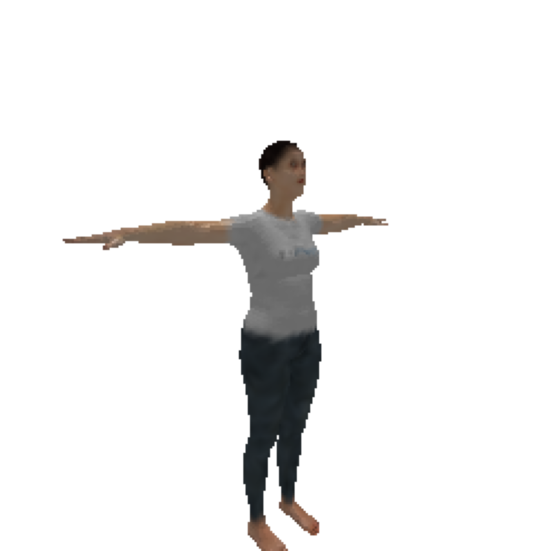

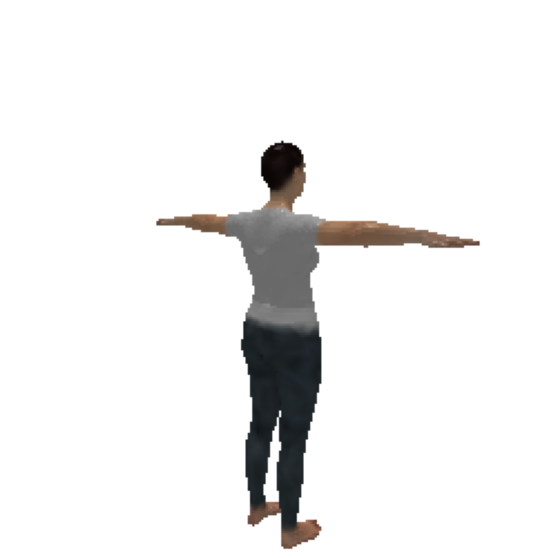

In [13]:
# a quick visualization of the rendered mesh
for test_img_t in test_imgs_t:
  plot_image_t(test_img_t)

## Test: CLIP

In [14]:
clip.available_models()

['RN50',
 'RN101',
 'RN50x4',
 'RN50x16',
 'RN50x64',
 'ViT-B/32',
 'ViT-B/16',
 'ViT-L/14',
 'ViT-L/14@336px']

In [15]:
clip_model = CLIPwrapper(model_name="ViT-B/32", device=dev)

100%|███████████████████████████████████████| 338M/338M [00:06<00:00, 55.5MiB/s]


#### Test: Our Implementation of CLIP Image Preprocessing

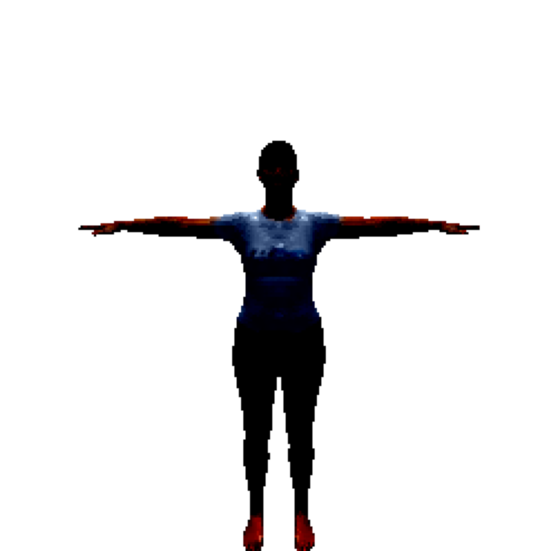

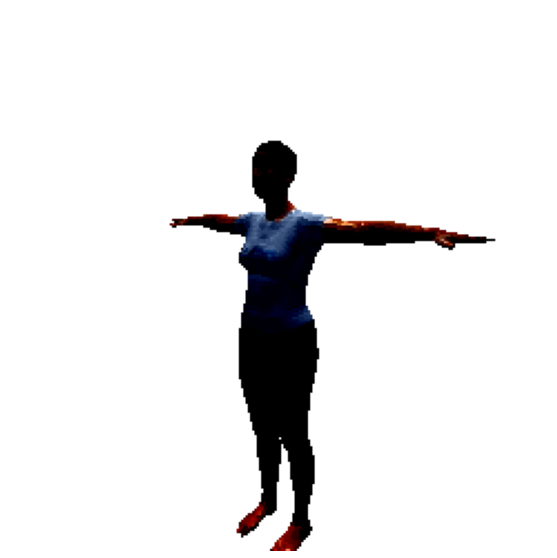

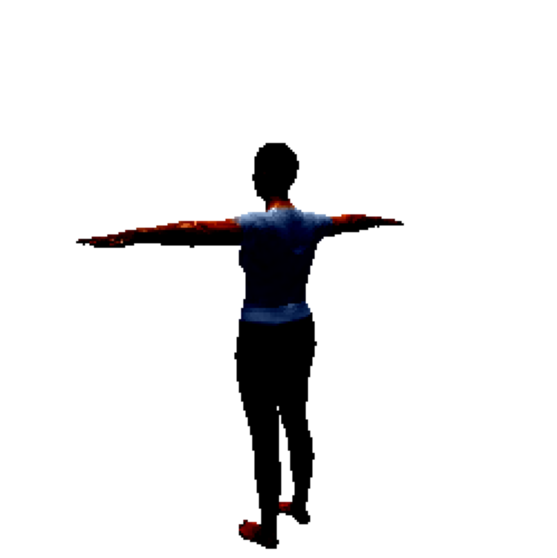

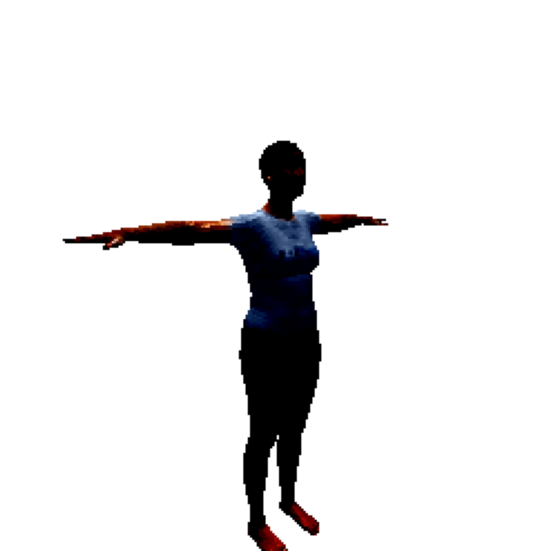

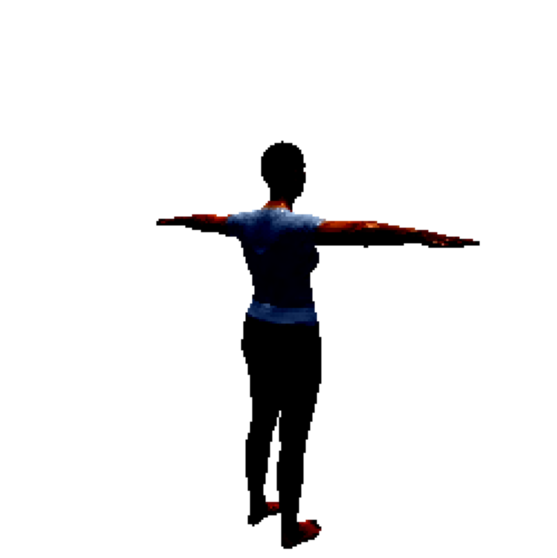

In [16]:
proc_test_imgs_t = torch.permute(clip_model.proc_imgs(test_imgs_t), (0, 2, 3, 1)) # N 3 W H => N W H 3 so 0 1 2 3 => 0 2 3 1
# a quick visualization of the processed images (matplotlib automatically clamps the pixels)
for proc_test_img_t in proc_test_imgs_t:
  plot_image_t(proc_test_img_t)

#### Test: How much does CLIP recognize our mesh and the position it is in ?

In [183]:
# a prompt describing the previous image
pmt_emb = clip_model.pmt_emb("""a white person wearing a grey T-shirt and dark pants, standing up on her straight legs with both arms apart and at the shoulder level.""")
imgs_embs = clip_model.imgs_embs(test_imgs_t)

In [184]:
imgs_embs.shape, pmt_emb.shape

(torch.Size([5, 512]), torch.Size([1, 512]))

In [185]:
img_emb = imgs_embs.mean(axis=0, keepdims=True)
float(cos_dist(img_emb, pmt_emb))

0.6923828125

In [186]:
cosine_distances = torch.Tensor([cos_dist(img_emb.unsqueeze(0), pmt_emb) for img_emb in imgs_embs])
cosine_distances

tensor([0.6860, 0.6787, 0.7188, 0.6953, 0.7100])

In [187]:
float(cosine_distances.mean())

0.69775390625

## Prompts

In [284]:
pe1 = clip_model.pmt_emb("a white person wearing a grey T-shirt and dark pants, standing up straight on her feet. She is looking upfront with both her hands raised up above her head")
pe2 = clip_model.pmt_emb("a white person wearing a grey T-shirt and dark pants, standing up straight on her feet. Both her hands raised up above her head. She is looking upfront.")
pe3 = clip_model.pmt_emb("a white person wearing a grey T-shirt and dark pants. She is standing up on her feer, with both her hands raised up above her head.")
cos_dist(pe1, pe2)

tensor([0.0171], device='cuda:0', dtype=torch.float16, grad_fn=<RsubBackward1>)

## MODELS


In [299]:
# create a model factory
model_context = SimpledCLIPContext(smpl_model, renderer, clip_model) 
MODELS = {
    "P1": model_context.create(
        prompt="""a white person wearing a grey T-shirt and dark pants. She is standing up straight on her feet. Both her hands raised up above her head. She is looking upfront."""),
    "P2": model_context.create(
        prompt="""a white person wearing a grey T-shirt and dark pants. She is sitting."""),
    }

### Test: Does the model work ?

In [286]:
pose, shape = init_weights(dev)
test_imgs_embs, test_pmt_emb = MODELS["P1"](pose, shape)
test_imgs_embs.shape, test_pmt_emb.shape

(torch.Size([5, 512]), torch.Size([1, 512]))

### Optimization

In [294]:
# optimization config
optim_config = {
    "lr": 0.8*1e-3,
    "betas": (0.9, 0.999),

    "loss_mode": "average-loss-on-embeddings"
}

# optimization config when using learning rate scheduler
lrsch_optim_config = {
    "lr": 2*1e-3,
    "betas": (0.9, 0.999),

    "loss_mode": "average-loss-on-embeddings",

    "sch_factor": 0.5,
    "sch_patience": 10,
    "sch_threshold": 5*1e-3,
    "sch_min_lr": 1e-4,
    "sch_cooldown": 20,
    "sch_verbose": True
}

# tracker config
tracker_config = {
    "loss": {"interleaving": 10}, 
    "pose": {"interleaving": 100},
    "shape": {"interleaving": 100}
}


def run_optimization(model, optim_config, n_passes=1000, activate_lr_sch=False):
  # weights used in optimization
  pose, shape = init_weights(device=dev) 
  # optimize with respect to the pose only
  optimenv = OptimEnv(model=model, weights=[pose], activate_lr_sch=activate_lr_sch, config=optim_config) 
  result = optimenv.optimize(pose=pose, shape=shape, n_passes=n_passes, tracker_config=tracker_config)
  return result

def intermediate_views(result, coords):
  visu_smpl_model = SMPLwrapper(model=None, batchsize=1, txmapping=texture_generator, device=dev) #model=None uses the default model
  visu_camera = camsfactory.fov_persp_scs(coords=coords, fov=60, frustrum_depth=(1, 100))
  visu_renderer = Renderer(cameras=visu_camera, device=dev)
  
  pose_shape = zip(result["tracked"]["poses"]["pose"], result["tracked"]["shapes"]["shape"])
  for pose, shape in pose_shape:
    pose, shape = pose.to(dev), shape.to(dev)
    mesh = visu_smpl_model.meshes(theta=pose, beta=shape)
    image = visu_renderer.render(mesh)
    plot_image_t(image.squeeze())

### Results

In [295]:
p1_result = run_optimization(model=MODELS["P1"], optim_config=optim_config, n_passes=1000, activate_lr_sch=False)

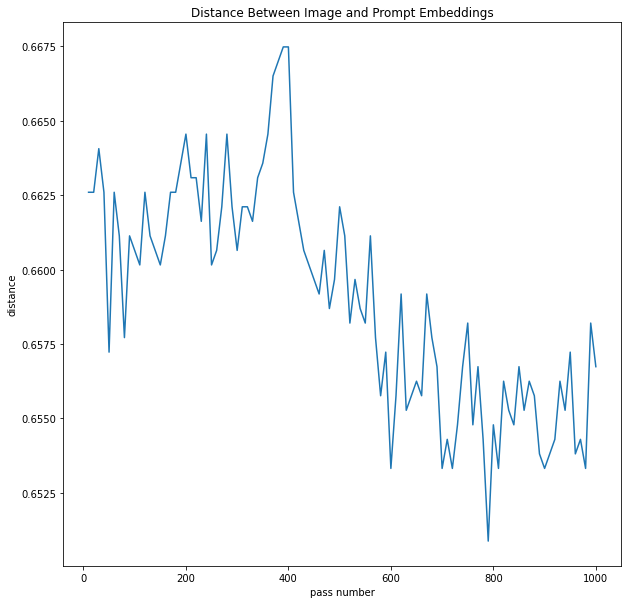

In [296]:
plot_losses(p1_result["tracked"]["losses"])

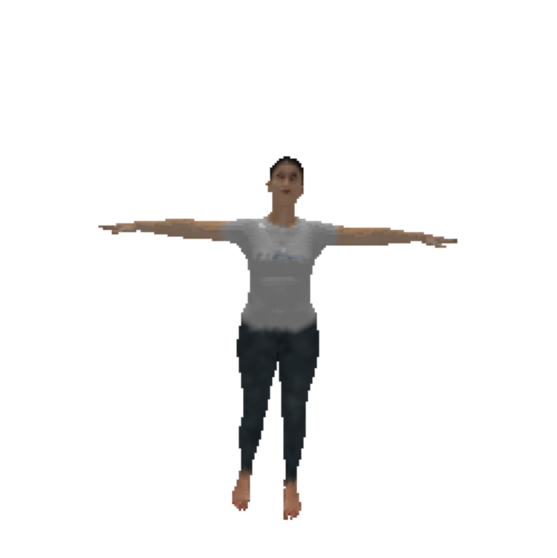

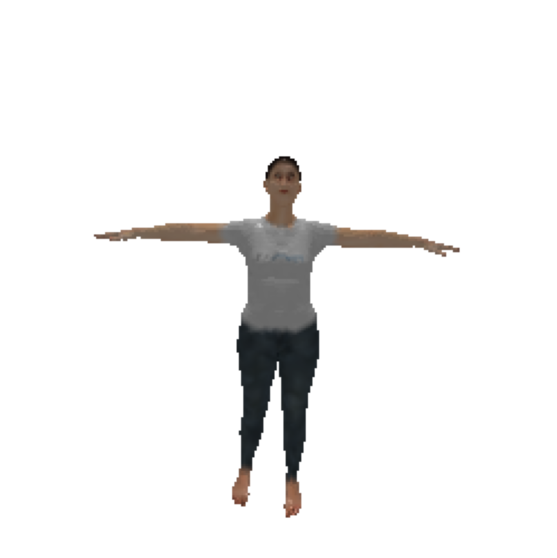

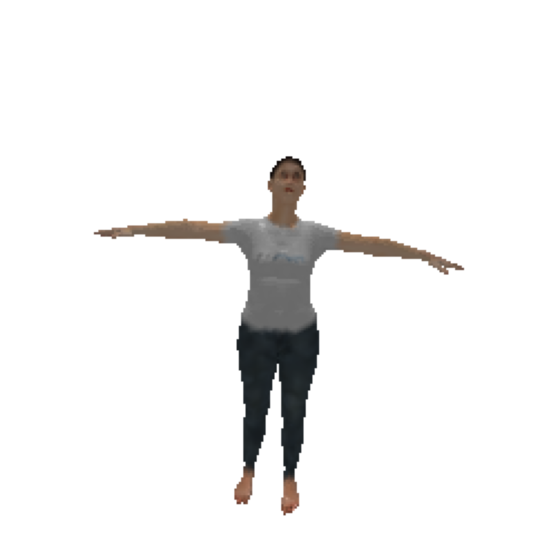

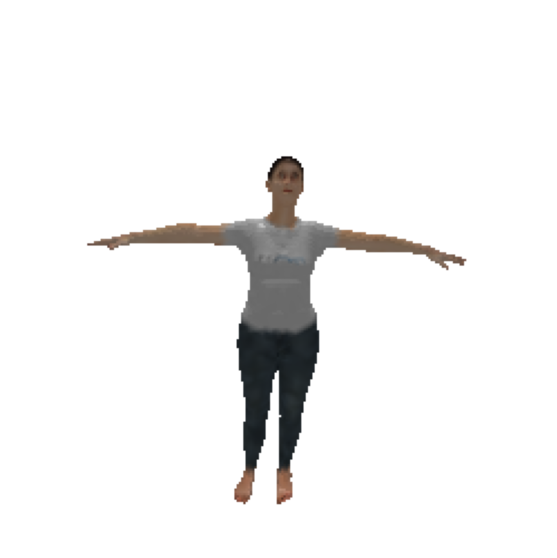

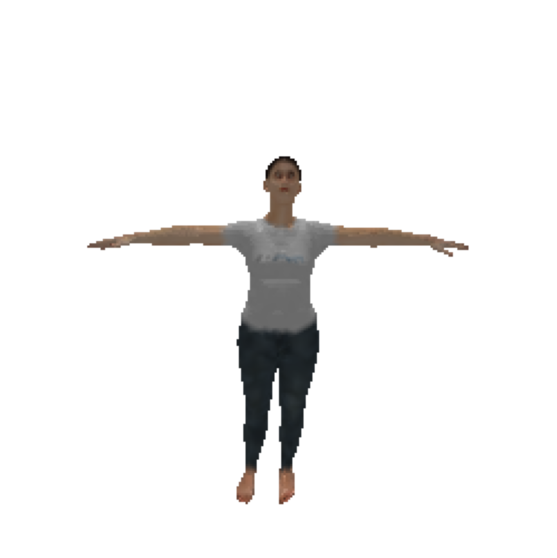

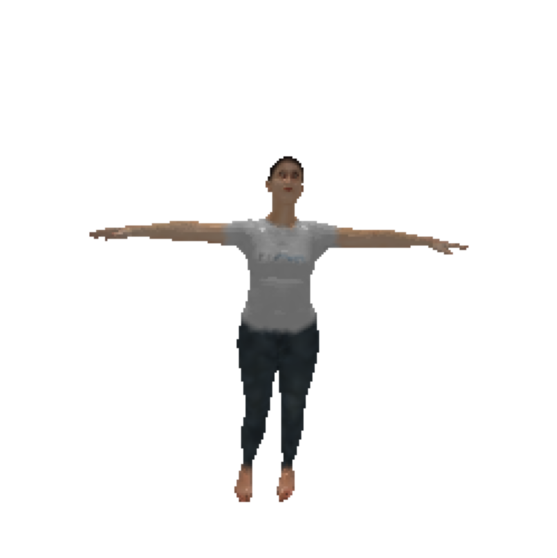

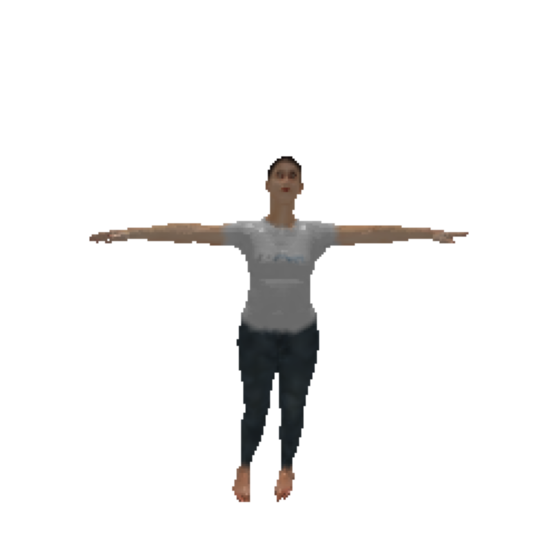

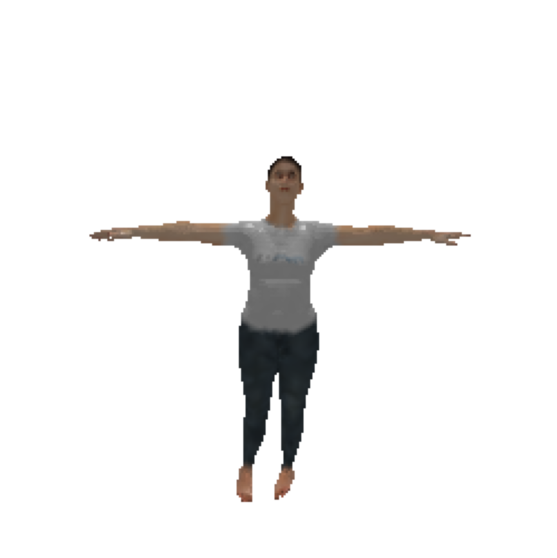

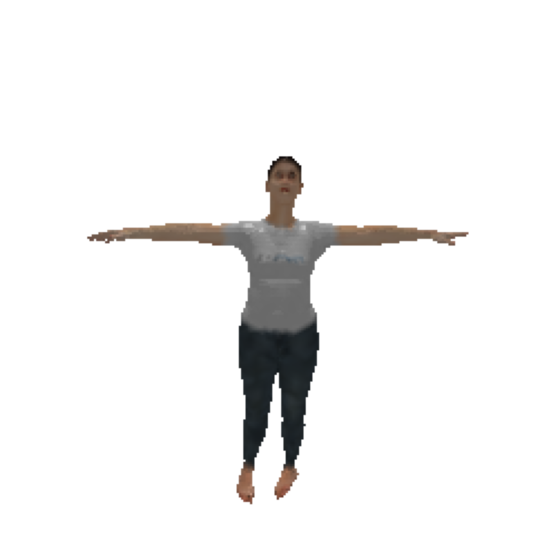

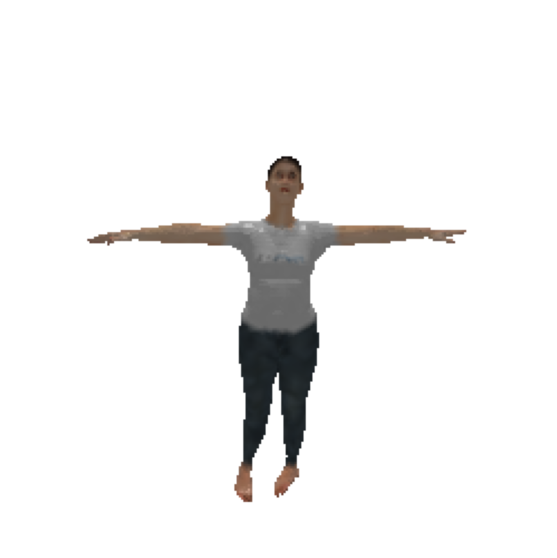

In [297]:
intermediate_views(p1_result, coords=(2.25, 0, 10))

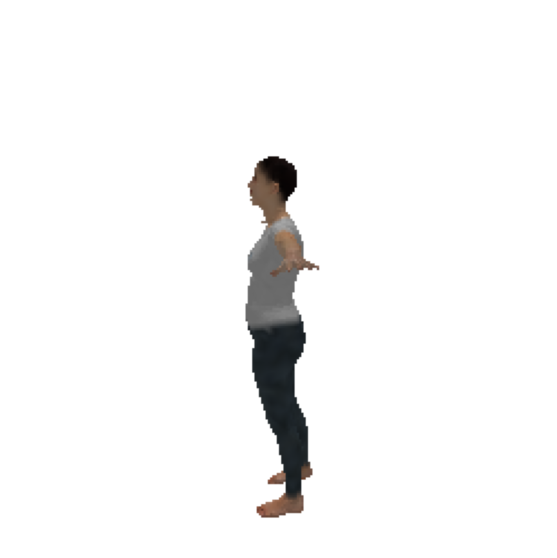

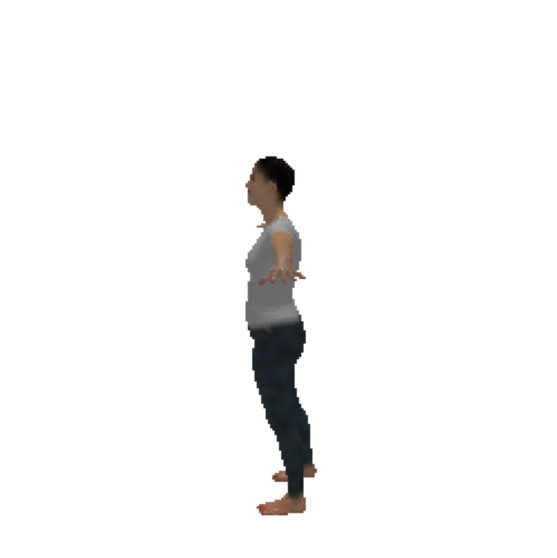

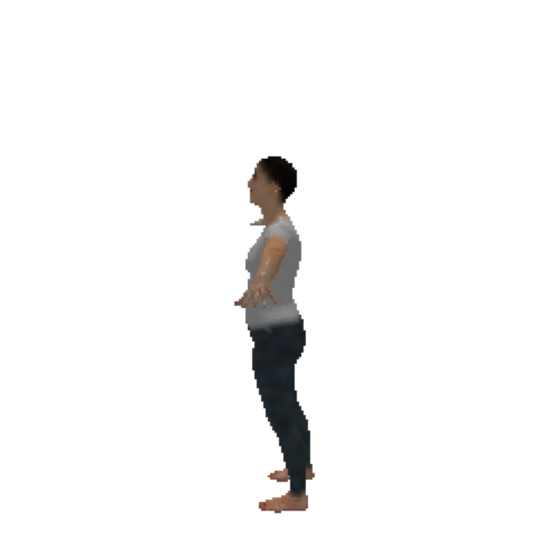

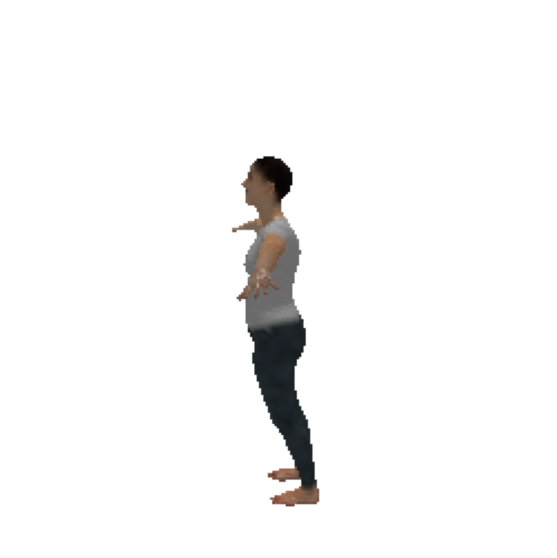

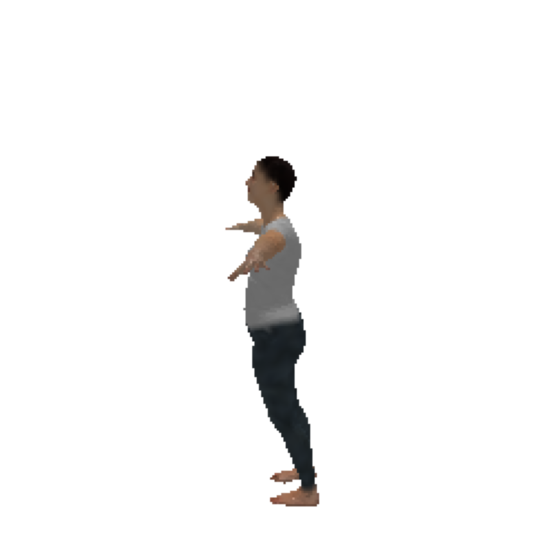

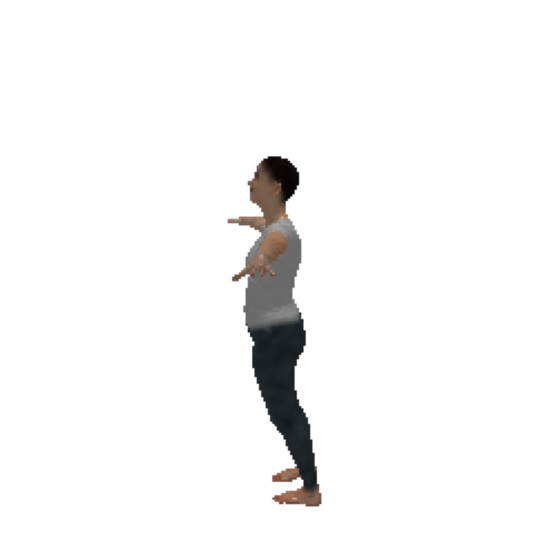

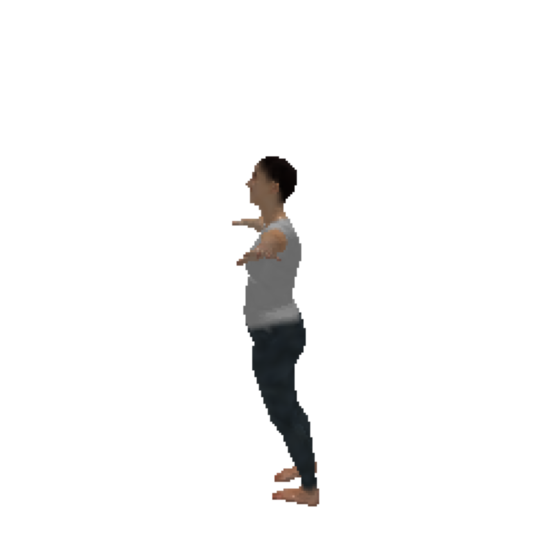

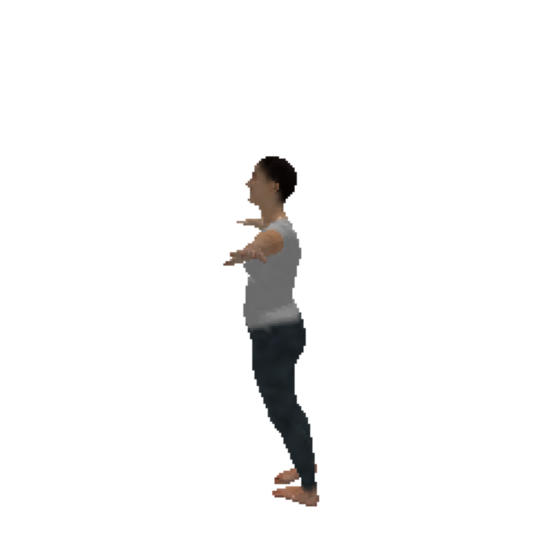

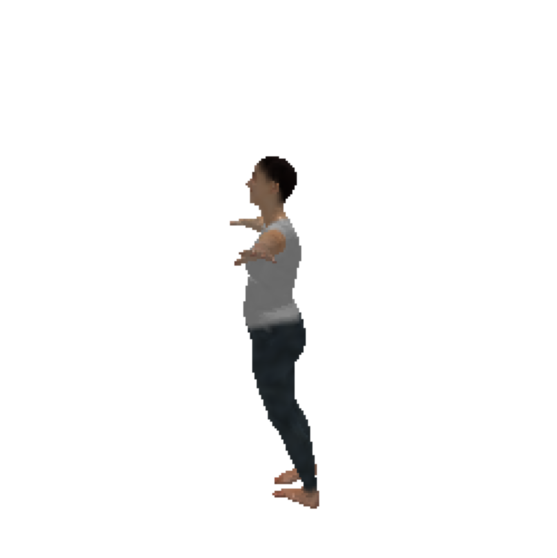

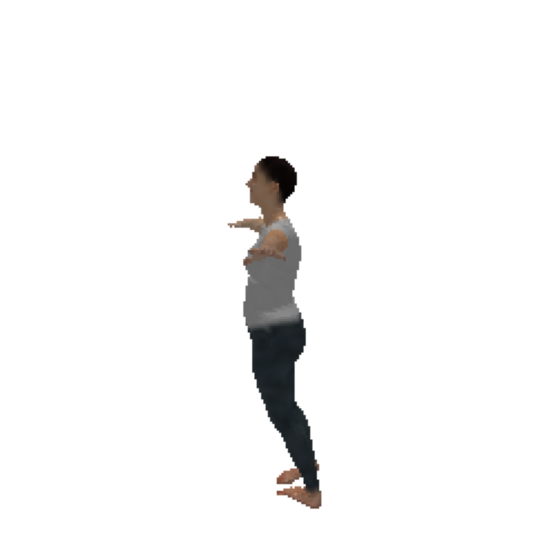

In [298]:
intermediate_views(p1_result, coords=(2.25, 90, 10))

In [300]:
p2_result = run_optimization(model=MODELS["P2"], optim_config=optim_config, n_passes=1000, activate_lr_sch=False)

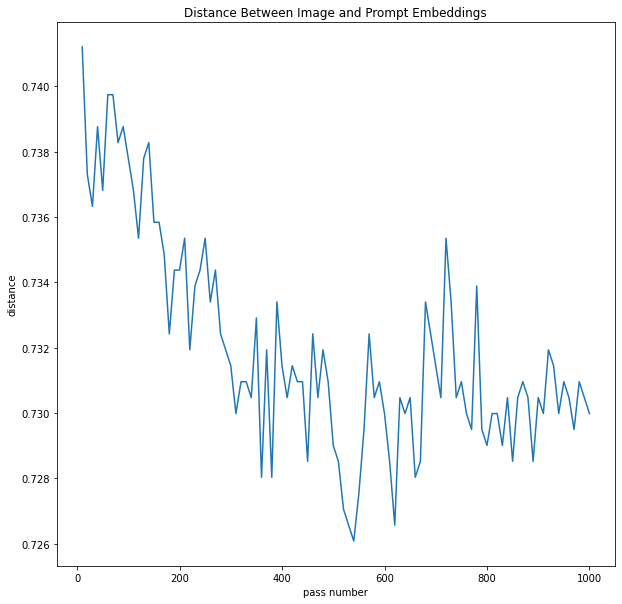

In [301]:
plot_losses(p2_result["tracked"]["losses"])

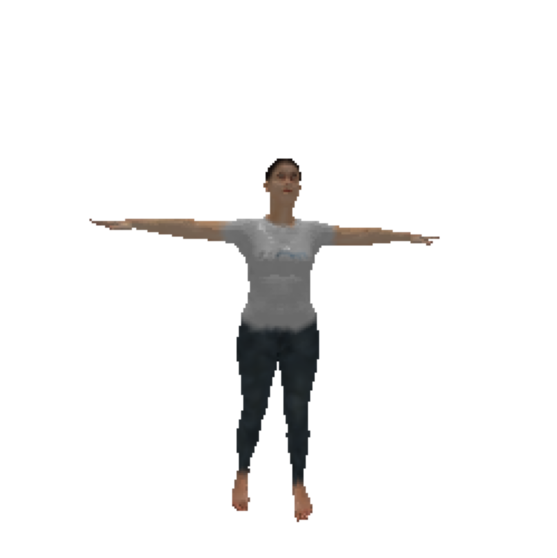

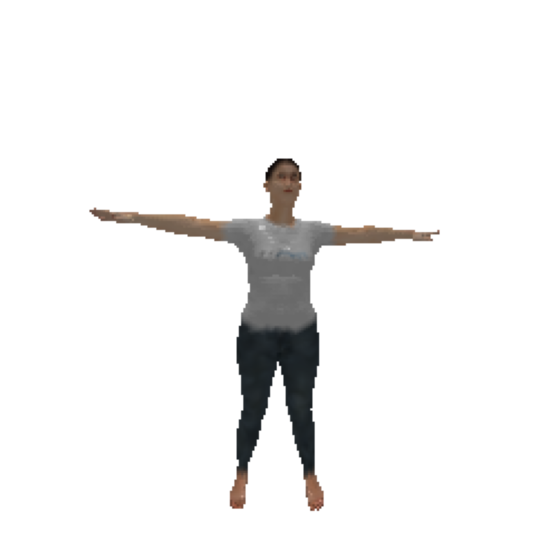

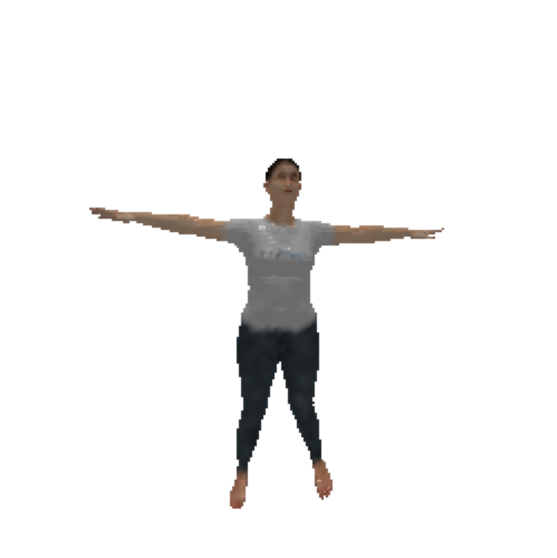

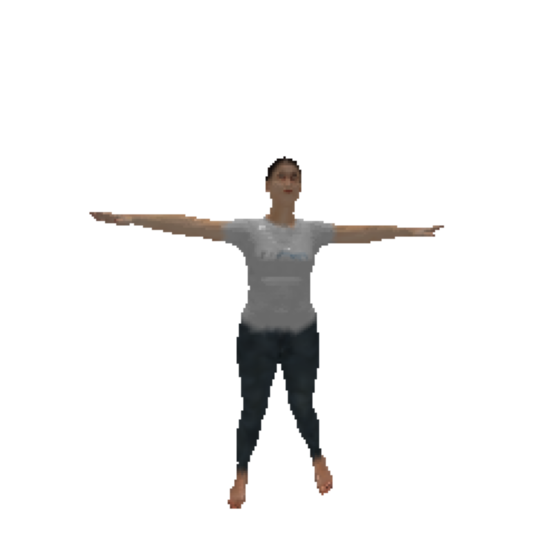

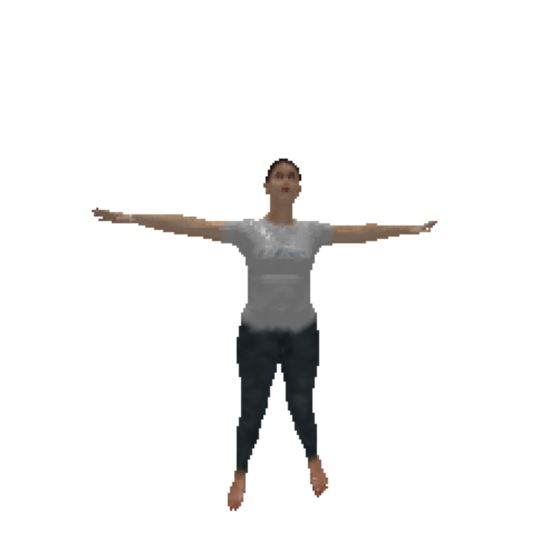

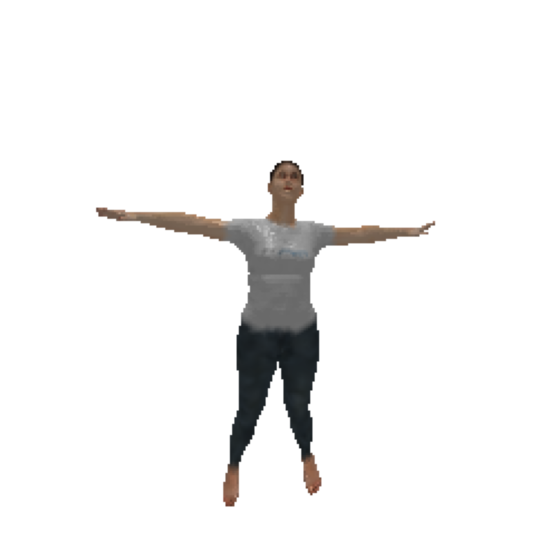

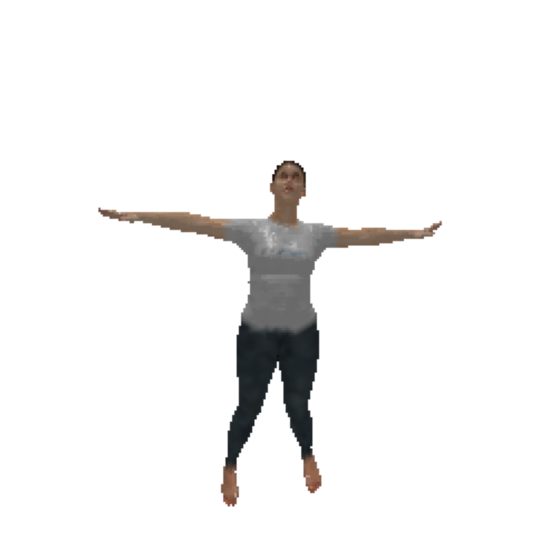

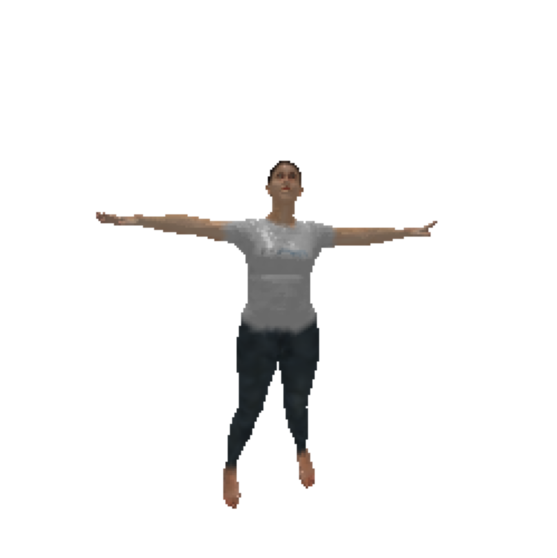

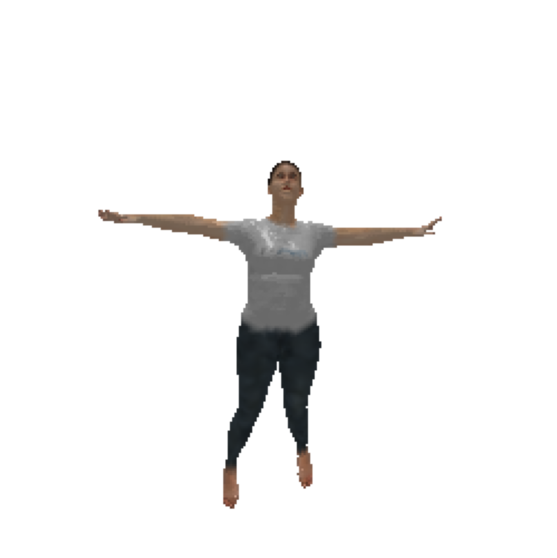

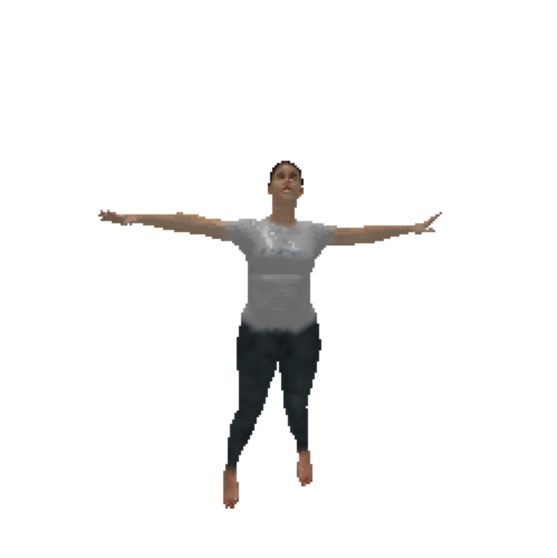

In [302]:
intermediate_views(p2_result, coords=(2.25, 0, 10))

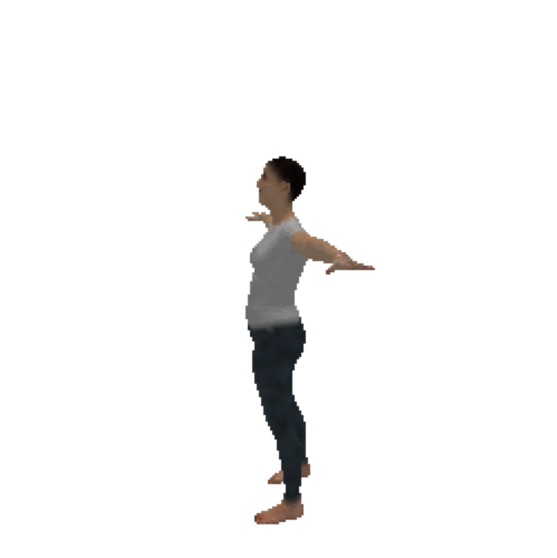

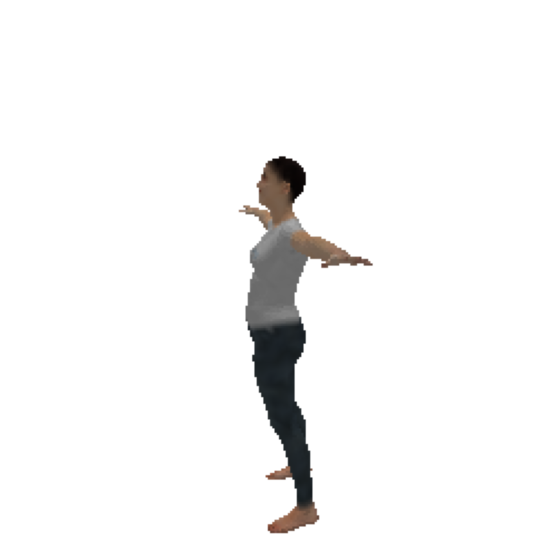

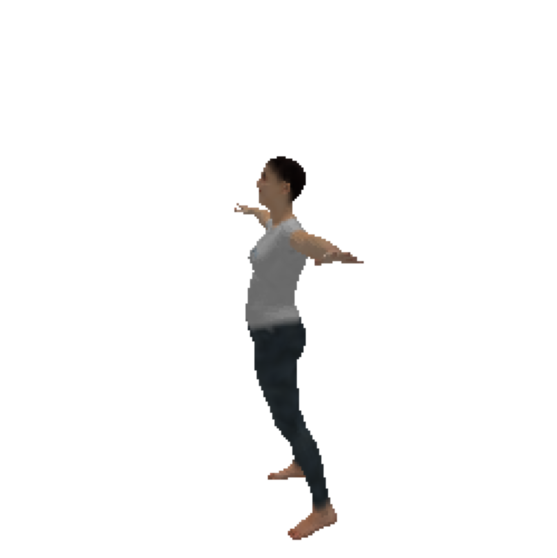

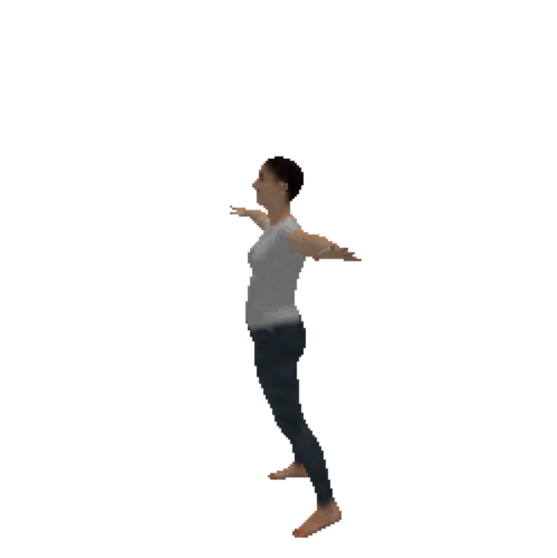

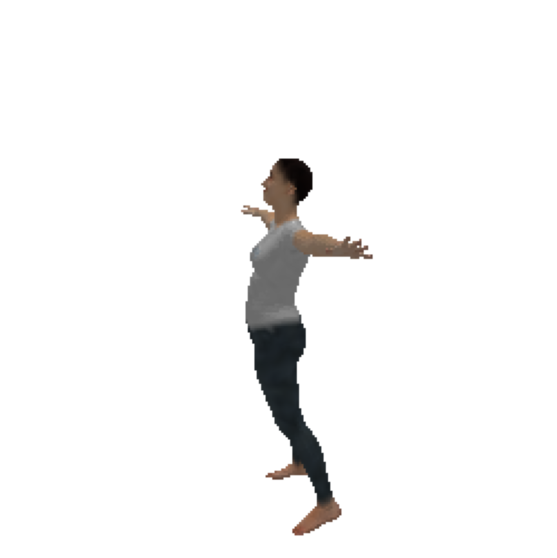

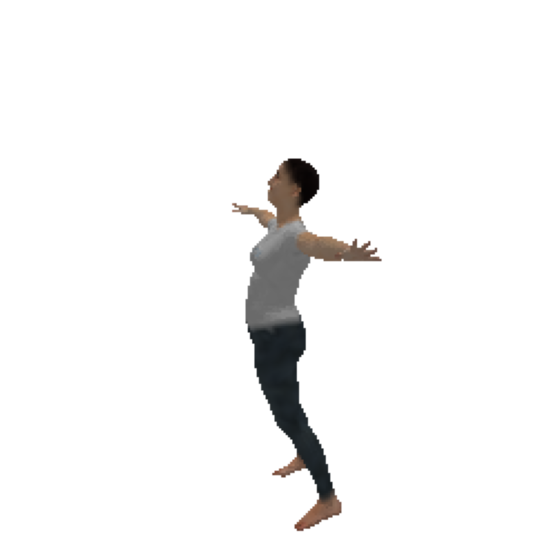

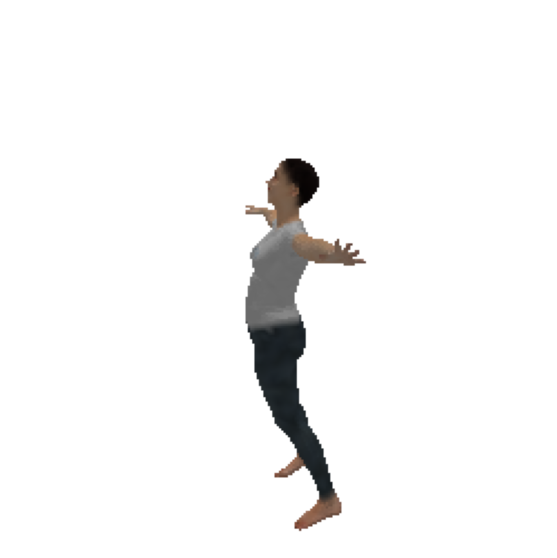

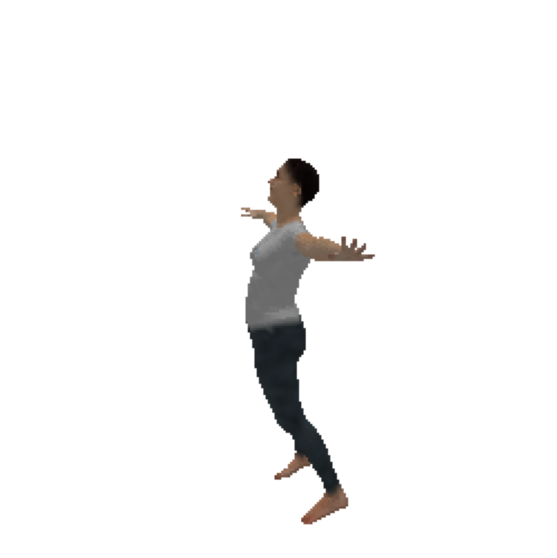

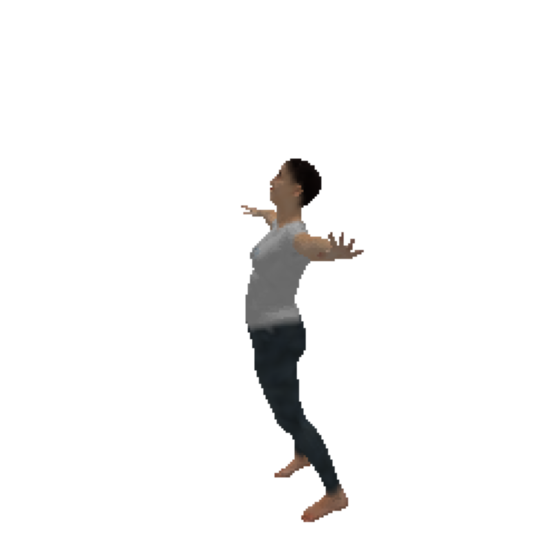

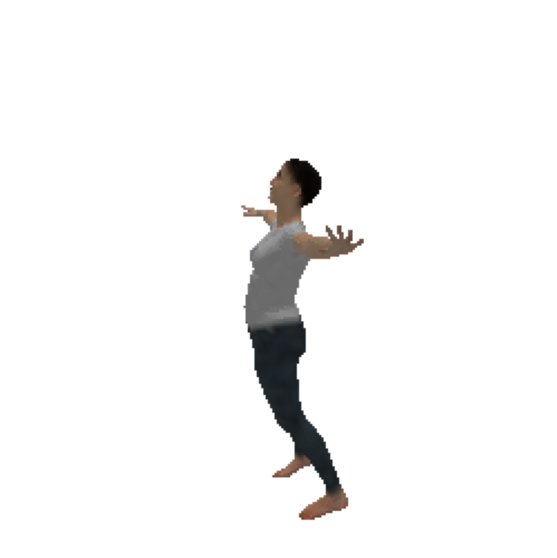

In [303]:
intermediate_views(p2_result, coords=(2.25, 90, 10))

In [234]:
p1_LRsch_result = run_optimization(MODELS["P1"], optim_config=lrsch_optim_config, n_passes=1000, activate_lr_sch=True)

Epoch 00016: reducing learning rate of group 0 to 1.0000e-03.
Epoch 00047: reducing learning rate of group 0 to 5.0000e-04.
Epoch 00078: reducing learning rate of group 0 to 2.5000e-04.
Epoch 00109: reducing learning rate of group 0 to 1.2500e-04.
Epoch 00140: reducing learning rate of group 0 to 1.0000e-04.


KeyboardInterrupt: ignored

In [ ]:
plot_losses(p1_LRsch_result["tracked"]["losses"])

In [ ]:
intermediate_views(p1_LRsch_result, coords=(2.25, 0, 3))

In [ ]:
intermediate_views(p1_LRsch_result, coords=(2.25, 90, 10))

In [ ]:
optim_config_2 = {
    "lr": 1e-3,
    "betas": (0.9, 0.999),

    "loss_mode": "loss-of-average-embedding"
}

In [ ]:
p1_result_2 = run_optimization(model=MODELS["P1"], optim_config=optim_config_2, n_passes=1000, activate_lr_sch=False)

In [ ]:
plot_losses(p1_result_2["tracked"]["losses"])

In [ ]:
intermediate_views(p1_result_2, coords=(2.25, 0, 10))

In [ ]:
intermediate_views(p1_result_2, coords=(2.25, 90, 10))